# components for the "walkin" model

JMA 4 Nov 2023

In [35]:
import math, os, re, sys
import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import nbinom, poisson
import matplotlib.pyplot as plt

In [36]:
# walk-in distribution parameters
k = 1000
n = 6
p = 0.07
bin_size = 12
# asymmetric costs
under_provision_cost = -0.02
over_provision_cost = -0.06

In [37]:
# a negative binomial rv 
nb_sample = nbinom.rvs(n, p, size=k)
np_hist = np.histogram(nb_sample, density=True, bins = [1 + k for k in range(0, 158,12)])


In [38]:
np_hist

(array([0.00017112, 0.00188227, 0.00521903, 0.00744353, 0.01249144,
        0.0136037 , 0.01266256, 0.01026694, 0.00727242, 0.00479124,
        0.00419233, 0.00239562, 0.00094114]),
 array([  1,  13,  25,  37,  49,  61,  73,  85,  97, 109, 121, 133, 145,
        157]))

In [39]:
np_density = np_hist[0]
ends = np_hist[1]
ends_ar = np.vstack([ends[:-1], ends[1:]])
mid_points = (ends_ar.sum(axis=0)/2).astype('int')
len(mid_points), '\n', mid_points

(13,
 '\n',
 array([  7,  19,  31,  43,  55,  67,  79,  91, 103, 115, 127, 139, 151]))

In [40]:
# The rv must  be calculated at integer values
nb_mean = n *(1-p)/p
print(f'mean {nb_mean}, sd {math.sqrt(nb_mean/p)}')

mean 79.71428571428571, sd 33.74574803147919


Text(0.5, 1.0, 'Negative Binomial fit versus Poisson with mean = 79.7')

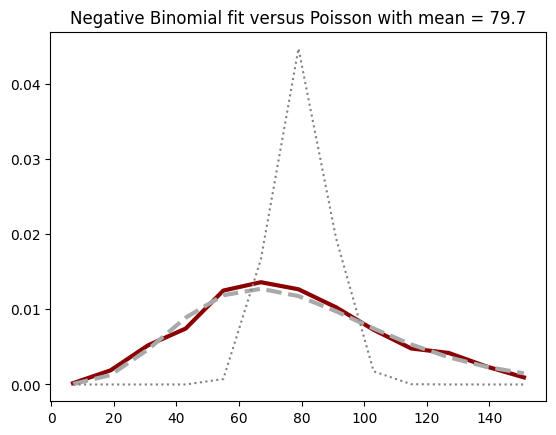

In [41]:
#v = range(1,200) #np.linspace(np_hist[1][0], np_hist[1][-1])
nb_p = nbinom.pmf(mid_points, n, p)
fig, ax = plt.subplots()
ax.plot(mid_points, np_density, color = 'darkred', linewidth=3)
ax.plot(mid_points, nb_p, color = 'darkgrey', linestyle='--', linewidth=3)
# Add the poisson with the same mean
ax.plot(mid_points, poisson.pmf(mid_points, nb_mean) , color='grey', linestyle= ':')
ax.set_title(f'Negative Binomial fit versus Poisson with mean = {nb_mean:.3}')

## Finding the lowest cost tradeoff for an asymmetric linear value function. 

We take the expected value for the value function as we vary the minimum point in the function.


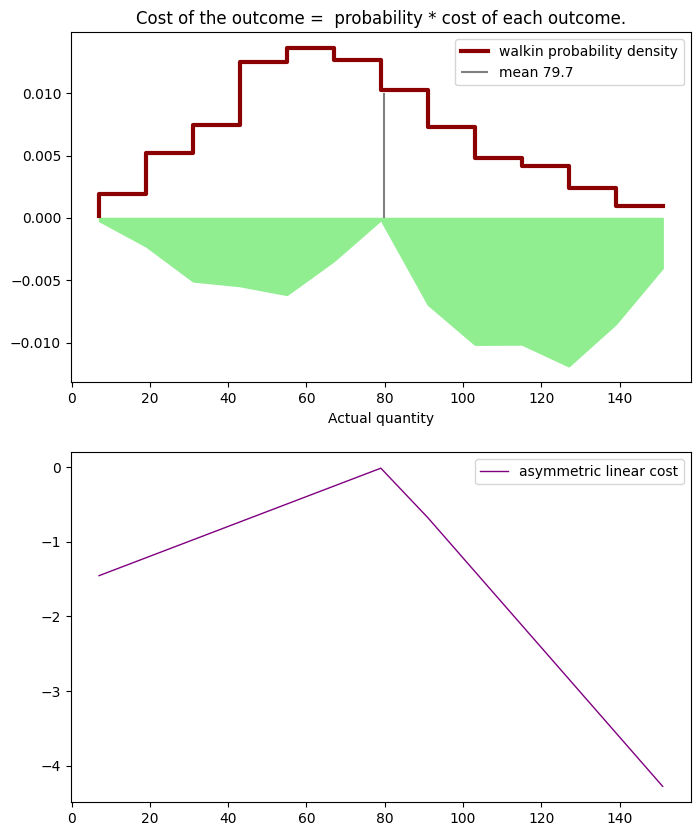

In [42]:
def Value(x, min_point, lower_v, upper_v):
    if x < min_point:
        return (min_point - x) * lower_v
    else:
        return (x - min_point) * upper_v

cost_fn = [Value(z, nb_mean, under_provision_cost, over_provision_cost) for z in mid_points]
expected_cost =  np.multiply(cost_fn, np_density)
fig, (ax1, ax2) = plt.subplots(2,1, figsize = (8,10))
ax1.step(mid_points,  np_density, color = 'darkred', linewidth=3, label='walkin probability density')
ax1.vlines(nb_mean, ymin=0, ymax = 0.01,color = 'grey', label = f'mean {nb_mean:.3}')
ax2.plot(mid_points, cost_fn, color = 'purple', linewidth=1, label='asymmetric linear cost')
ax1.stackplot(mid_points, expected_cost, color = 'lightgreen', linewidth=1)#, label='loss')
ax1.legend()
ax1.text(100,-0.02, 'E[Cost | outcome]')
ax1.set_xlabel('Actual quantity')
ax1.set_title('Cost of the outcome =  probability * cost of each outcome.')
ax2.legend()

## Converting the histogram to a continuous Metalog

This requires a few manual steps. 
- Create a DataFrame with no index or header & no 0, 1 values
- Create the required number of rows in the Metalog editor & paste from the clipboard
- Copy the resulting Metalog expression into an equation node. Keep the interval definition
- Set the number of discretizations and convert to a chance node. 

In [43]:
# Create the CPD histogram. Learn the Metalog from them.
# Use the clipboard copy to load in excel. 
#  
cpd = pd.DataFrame({'Density':bin_size *np_density.cumsum(), 'RV':mid_points}, index=None)
# The Metalog requires positive probabilities only
cpd.Density.iloc[0] = 0.001
cpd.Density.iloc[-1] = 0.999
print(cpd.shape)
#print(cpd.to_string(index=False))
cpd.to_clipboard(sep='\t', index=False, header=None)

(13, 2)


/tmp/ipykernel_31218/1414353495.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cpd.Density.iloc[0] = 0.001
/tmp/ipykernel_31218/1414353495.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cpd.Density.iloc[-1] = 0.999


In [44]:
# The tab separated bin values are needed for the sub-utility nodes in Genie to convert from states
# into choice and random variables. 
cpd.shape, list(cpd.RV)
for k in list(cpd.RV):
    print(k, end='\t')
print()

7	19	31	43	55	67	79	91	103	115	127	139	151	


In [45]:
for k in list(cpd.RV):
    print(k)
print()

7
19
31
43
55
67
79
91
103
115
127
139
151



In [46]:
# Paste the discretized chance node values from the Metalog node from Genie here. 
discretized_ml = '''0.001801621459313382
0.0198178360524472
0.08537683915523972
0.1459313382043839
0.1532379141227104
0.1347212491242118
0.1200080072064858
0.09948954058652787
0.08527674907416675
0.07136422780502452
0.05504954459013112
0.02262035832249024
0.00530477429686718
'''

density_ml = np.array([float(z) for z in discretized_ml.split()]).reshape(13,1)

#pd.DataFrame(discretized_ml)

In [47]:
# rv_points = [f'Q_{z}' for z in mid_points]
# cpd = pd.DataFrame({'RV':rv_points, 'Density':5 *np_density }, index=None)
# cpd.to_clipboard(sep='\t')

In [48]:
# metxt = '''Metalog(2,Inf(),\
# 3,5,8,13,18,23,28,33,38,43,48,53,58,63,68,73,78,83,88,93,98,103,108,113,118,123,128,133,138,143,148,153,158,163,168,173,178,183,188,193,198,\
# 0.000200441,0.000601323,0.00220485,0.00891962,0.0202445,0.0392864,0.0679495,0.10443,0.14071,0.19082,0.250351,0.310984,0.37272,0.439266,0.502205,0.56364,0.617559,0.674283,0.720084,0.758769,0.796753,0.828523,0.857086,0.880637,0.903989,0.925135,0.94087,0.952395,0.962016,0.971337,0.97725,0.983063,0.985668,0.988876,0.99078,0.993085,0.99529,0.996693,0.998296,0.999298)'''
# # Discard the prefix
# metal = re.sub('Metalog', '', metxt)
# metal = re.sub(r'\([0-9]+,[^,]+,', '', metal)[:-1]
# m_floats = [float(z) for z in metal.split(',')]
# bin_cnt = len(m_floats)//2
# ends_ar = np.vstack([m_floats[1:(bin_cnt +1)], m_floats[:(bin_cnt)]])
# meta_mid_points = (ends_ar.sum(axis=0)/2).astype('int')
# meta_cdf = m_floats[bin_cnt+1:]

Text(0.5, 0, 'Actual quantity')

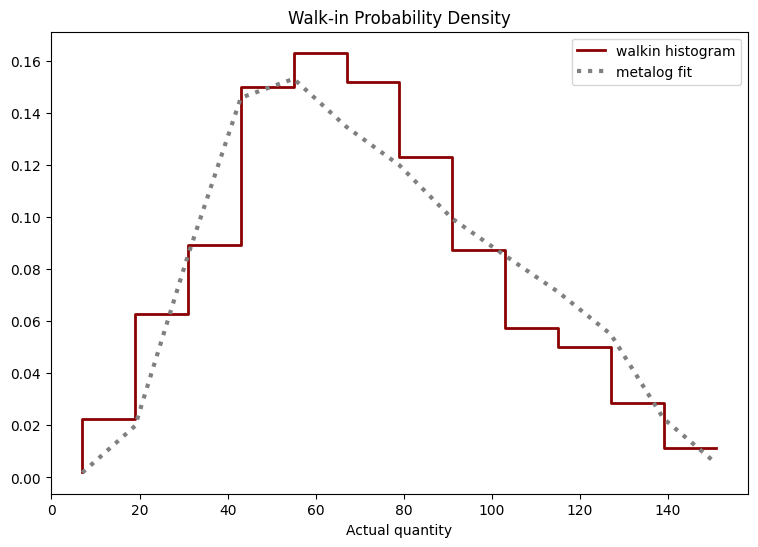

In [49]:

fig, ax1 = plt.subplots(figsize = (9,6))
ax1.step(mid_points, bin_size * np_density, color = 'darkred', linewidth=2, label='walkin histogram')
ax1.plot(mid_points, density_ml, color='grey', linestyle = ':', linewidth=3, label='metalog fit')
ax1.legend()
# ax2.plot(mid_points, cost_as_function_of_items)
# ax2.plot(min_pt, min_v, 'd', color = 'black', markersize=10)
ax1.set_title('Walk-in Probability Density')
ax1.set_xlabel('Actual quantity')
#ax2.set_title(f'Cost as a function of Items on Hand. Optimum ={min_pt}')

Text(0.5, 1.0, 'Cost of the outcome =  probability * cost of each outcome.')

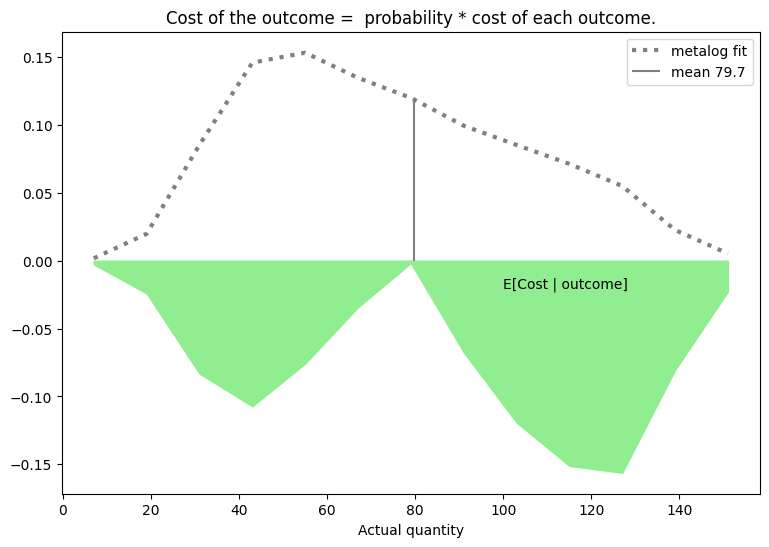

In [50]:
cost_fn = np.array([Value(z, nb_mean, under_provision_cost, over_provision_cost) for z in mid_points])
cost_fn.reshape(13,1)
cost_fn = cost_fn.reshape(13,1)
expected_cost =  np.multiply(cost_fn, density_ml) # np.multiply(cost_fn, density_ml/12)
expected_cost = expected_cost.reshape((13,))
fig, ax1 = plt.subplots(figsize = (9,6))
ax1.plot(mid_points, density_ml, color='grey', linestyle = ':', linewidth=3, label='metalog fit')
# ax1.step(mid_points,  np_density, color = 'darkred', linewidth=3, label='walkin probability density')
ax1.vlines(nb_mean, ymin=0, ymax = 0.12,color = 'grey', label = f'mean {nb_mean:.3}')
ax1.fill_between(mid_points, expected_cost, color = 'lightgreen', linewidth=1)#, label='loss')
ax1.legend()
ax1.text(100,-0.02, 'E[Cost | outcome]')
ax1.set_xlabel('Actual quantity')
ax1.set_title('Cost of the outcome =  probability * cost of each outcome.')


Text(0.5, 1.0, 'Cost as a function of Items on Hand. Optimum =91')

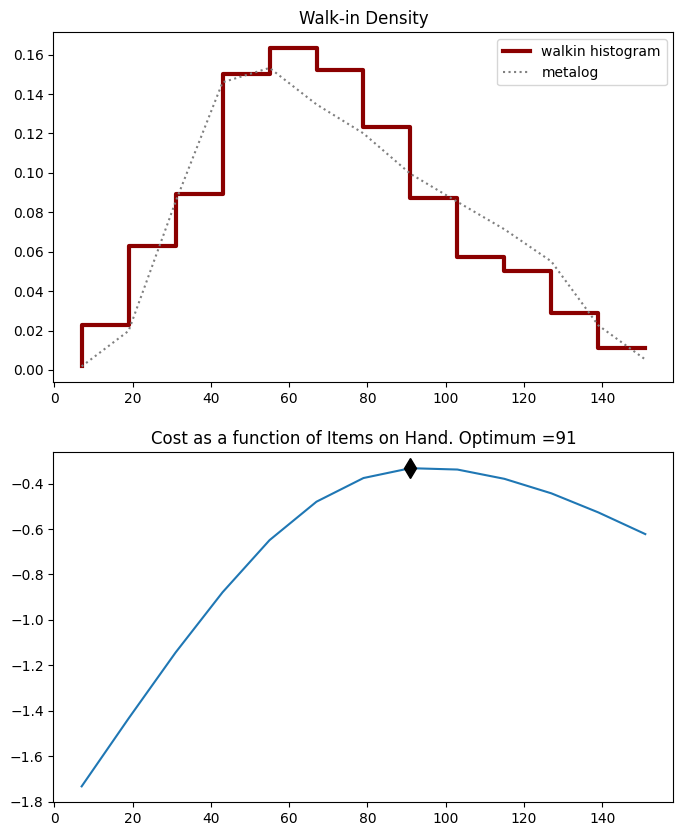

In [51]:
# Vary the expected cost min over the range of outcomes to find the optimal number of items on hand
def expected_cost_enumeration(v):
    cost = []
    find_min = -1e6
    min_cost = None
    for min_point in v:
        cost_fn = [Value(z, min_point, -0.1, -0.3) for z in v]
        expected_cost =  np.multiply(cost_fn, np_hist[0]).sum()
        cost.append(expected_cost)
        if expected_cost > find_min:
            find_min = expected_cost
            min_cost_pt = min_point
            min_cost_v = expected_cost
    return cost, min_cost_pt, min_cost_v

cost_as_function_of_items, min_pt, min_v = expected_cost_enumeration(mid_points)
fig, (ax1, ax2) = plt.subplots(2,1, figsize = (8,10))
ax1.step(mid_points, bin_size * np_density, color = 'darkred', linewidth=3, label='walkin histogram')
ax1.plot(mid_points, density_ml, color='grey', linestyle = ':', label='metalog')
ax1.legend()
ax2.plot(mid_points, cost_as_function_of_items)
ax2.plot(min_pt, min_v, 'd', color = 'black', markersize=10)
ax1.set_title('Walk-in Density')
ax2.set_title(f'Cost as a function of Items on Hand. Optimum ={min_pt}')
# ax2.text(100, -4.2,f'Optimal items on hand is {min_cost}')